In [11]:
import degirum as dg
import numpy as np
import cv2

In [12]:
dg.__version__

'0.9.0'

In [13]:
class Yolov6FaceDetection(dg.postprocessor.DetectionResults):
    
    def __init__(self, *args, **kwargs): 
        super().__init__(*args, **kwargs)
        new_inference_results=[]
        def nms(boxes, overlap_threshold=0.5, min_mode=False):
            x1 = boxes[:, 0]
            y1 = boxes[:, 1]
            x2 = boxes[:, 2]
            y2 = boxes[:, 3]
            scores = boxes[:, 4]

            areas = (x2 - x1 + 1) * (y2 - y1 + 1)
            index_array = scores.argsort()[::-1]
            keep = []
            while index_array.size > 0:
                keep.append(index_array[0])
                x1_ = np.maximum(x1[index_array[0]], x1[index_array[1:]])
                y1_ = np.maximum(y1[index_array[0]], y1[index_array[1:]])
                x2_ = np.minimum(x2[index_array[0]], x2[index_array[1:]])
                y2_ = np.minimum(y2[index_array[0]], y2[index_array[1:]])

                w = np.maximum(0.0, x2_ - x1_ + 1)
                h = np.maximum(0.0, y2_ - y1_ + 1)
                inter = w * h

                if min_mode:
                    overlap = inter / np.minimum(areas[index_array[0]], areas[index_array[1:]])
                else:
                    overlap = inter / (areas[index_array[0]] + areas[index_array[1:]] - inter)

                inds = np.where(overlap <= overlap_threshold)[0]
                index_array = index_array[inds + 1]
            return keep
        
        def xywh2xyxy(x):
            '''Convert boxes with shape [n, 4] from [x, y, w, h] to [x1, y1, x2, y2] where x1y1 is top-left, x2y2=bottom-right.'''
            y = np.copy(x)
            y[:, 0] = x[:, 0] - x[:, 2] / 2  # top left x
            y[:, 1] = x[:, 1] - x[:, 3] / 2  # top left y
            y[:, 2] = x[:, 0] + x[:, 2] / 2  # bottom right x
            y[:, 3] = x[:, 1] + x[:, 3] / 2  # bottom right y
            return y
        
        def non_max_suppression_face_numpy(prediction, conf_thres=0.25, iou_thres=0.45, classes=None, agnostic=False, multi_label=False, max_det=300):
            output = []
            num_classes = prediction.shape[2] - 15
            pred_candidates = np.logical_and(prediction[..., 14] > conf_thres, np.max(prediction[..., 15:], axis=-1)[0] > conf_thres)  # candidates

            assert 0 <= conf_thres <= 1, f'conf_thresh must be in 0.0 to 1.0, however {conf_thres} is provided.'
            assert 0 <= iou_thres <= 1, f'iou_thres must be in 0.0 to 1.0, however {iou_thres} is provided.'

            # Function settings.
            max_wh = 4096  # maximum box width and height
            max_nms = 30000  # maximum number of boxes put into torchvision.ops.nms()
            time_limit = 10.0  # quit the function when nms cost time exceed the limit time.
            multi_label &= num_classes > 1  # multiple labels per box

            for img_idx, x in enumerate(prediction):  # image index, image inference
                x = x[pred_candidates[img_idx]]  # confidence
                # If no box remains, skip the next process.
                if not x.shape[0]:
                    continue

                # confidence multiply the objectness
                x[:, 15:] *= x[:, 14:15]  # conf = obj_conf * cls_conf
                # (center x, center y, width, height) to (x1, y1, x2, y2)
                box = xywh2xyxy(x[:, :4])
                class_idx = np.zeros(x[:, 15:].shape)
                reshaped_conf = np.reshape(x[:, 15:], (x[:, 15:].shape[0], 1))
                reshaped_class_idx = np.reshape(class_idx, (class_idx.shape[0], 1))
                x = np.concatenate((box,reshaped_conf,reshaped_class_idx,x[:, 4:14]),axis=1)
                num_box = x.shape[0]  # number of boxes

                if not num_box:  # no boxes kept.
                    continue
                elif num_box > max_nms:  # excess max boxes' number.
                    x = x[x[:, 4].argsort(descending=True)[:max_nms]]

                class_offset = x[:, 5:6] * (0 if agnostic else max_wh)  # classes
                boxes, scores = x[:, :4] + class_offset, x[:, 4]  # boxes (offset by class), scores
                prediction = np.concatenate((x[:, :4] + class_offset,reshaped_conf),axis=1)
                keep_boxes = nms(prediction)
                for i in keep_boxes:
                    output.append(x[i])
            return np.array(output)   
        
        
        for el in self._inference_results:
            prediction = el["data"]
            det = non_max_suppression_face_numpy(prediction, conf_thres=0.4, iou_thres=0.3, classes=None, agnostic=False, multi_label=False, max_det=300)
            for i,k in enumerate(det):
                result = {"bbox" : k[:4].tolist(), "category_id" : 0, "label" : "face", "score" : k[4], "landmarks" : [{"label" : 'LeftEye', "category_id" : 0, "landmark":k[6:8].tolist()},{"label" : 'RightEye', "category_id" : 1, "landmark":k[8:10].tolist()},{"label":'Nose',"category_id" : 2,"landmark":k[10:12].tolist()},{"label":'LipsleftCorner',"category_id" : 3,"landmark":k[12:14].tolist()},{"label":'LipsRightCorner',"category_id" : 4,"landmark":k[14:16].tolist()}]}
                box = result["bbox"]
                result["bbox"] = [
                    *self._conversion(*box[:2]),
                    *self._conversion(*box[2:]),
                ]
                for ldmks in result["landmarks"]:
                    ldmks["landmark"] = [*self._conversion(*ldmks["landmark"])]
                new_inference_results.append(result)
        self._inference_results = new_inference_results

In [19]:
zoo = dg.connect_model_zoo("0.0.0.0:8778")
model = zoo.load_model("yolo_v6n_face--512x512_float_openvino_cpu_1")
model.custom_postprocessor = Yolov6FaceDetection
model.image_backend = 'pil'

model.overlay_show_probabilities = False
model.overlay_show_labels = False
res = model("../../ppl7.jpg")

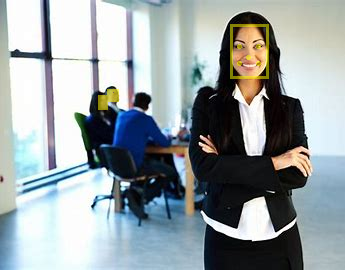

In [21]:
res.image_overlay

In [18]:
dg.__version__


'0.9.0'